# Part 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp

plt.rcParams["figure.figsize"] = (8,5)

- First let's figure out what 'two moon' look like

It's beautiful.


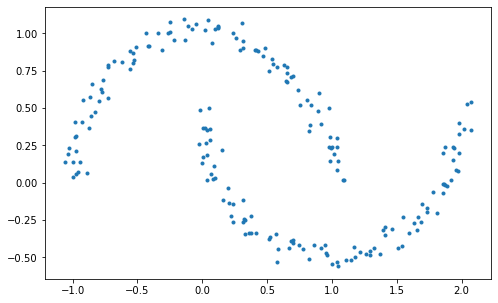

In [2]:
## Generate Data
from sklearn.datasets import make_moons

# Make two moons
moons_pos, moons_label = make_moons(n_samples=200, noise=0.05, shuffle=False, random_state=0)

# Plot two moons
plt.plot(moons_pos[:,0],moons_pos[:,1],'.')
print("It's beautiful.")

- Second, let's go to read the bloody paper

- Third, let's implement LapGMM

In [265]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from sklearn.neighbors import kneighbors_graph


class LapGMM:
    
    def __init__(self, data, K=2, p=8, lmd=1e3, tol=1e-6, weight_matrix='D-P',inner_max_iter = 200,outer_max_iter = 1000):
        '''
        Initilize the hyperparameter,
        Construct a nearest neighbor graph with weight matrix S,
        Initialize the parameters Theta_0 by using K-means algorithm.
        
        Input: 
        data: mxn np.array, m is the number of points, n is the dimension
        K: the number of clusters
        p: the number of nearest neighbors
        lmd: regularization parameter
        tol: the termination condition value
        '''
        
        # Initilize the hyperparameter
        self.random_seed = 0
        self.data = np.array(data)
        self.m, self.n = data.shape
        self.K = K
        self.p = p
        self.lmd = lmd
        self.tol = tol
        self.gamma = 0.9 # Set the initial value γ = 0.9
        self.weight_matrix = weight_matrix
        
        self.inner_max_iter = inner_max_iter
        self.outer_max_iter = outer_max_iter
        self.count = 1
        
        # Construct a nearest neighbor graph
        self._Construct_S()
        
        # Initialize the parameters Theta_0 and posterior probability by using K-means algorithm
        self._Init_Theta0()

        # Initialize the regularized log likelihood
        self.reg_loglikelihood = self._Eval_Regularized_LL(self.posterior_prob, self.alpha, self.mu, self.sigma,self.data)
        
    def _Construct_S(self):
        '''
        Construct a nearest neighbor graph with weight matrix S
        '''
        
        # Calculate the Euclidean distances
        #distance_matrix = np.linalg.norm(np.expand_dims(self.data,axis=1) - self.data, axis=-1)
        # Get the p nearest neighbors indices
        #kth = self.p
        #idx = np.argpartition(distance_matrix, kth=kth, axis=-1)[:,:kth]
        
        idx = kneighbors_graph(self.data, n_neighbors=self.p).toarray()
        
        # Initialize the weight matrix to zero
        self.S = np.zeros((self.m, self.m))
        
        for i in range(self.m):
            for j in range(self.m):
                
                if idx[i][j]==1:
                    
                    if self.weight_matrix=='0-1':
                        self.S[i,j]=1
                    elif self.weight_matrix.upper()=='H-K':
                        ##
                        # !!! This could be extended
                        ##
                        self.S[i,j]=1
                    elif self.weight_matrix.upper()=='D-P':
                        self.S[i,j]=np.dot(self.data[i,:],self.data[j,:])
                    else : 
                        raise ValueError('Please enter the correct definition of weight matrix.')
                        
                    self.S[j,i]=self.S[i,j] # note it is an undirected graph

        # construct L
        D = np.diag(np.sum(self.S, axis = 1))
        self.L = D-self.S
    
    def _Init_Theta0(self):
        # Use K-means as a warm start
        kmeans = KMeans(n_clusters=self.K, random_state=self.random_seed).fit(self.data)
        
        self.alpha = np.array([ np.sum(kmeans.labels_==i)/self.m for i in range(self.K)])

        self.mu = kmeans.cluster_centers_
        self.sigma = [np.cov(self.data[kmeans.labels_==i], rowvar=False) for i in range(self.K)]
        
        self.posterior_prob = self._E_step()
        
        
    def run(self):
        
        while self.count < self.outer_max_iter:
            self.gamma = 0.9 # Reset the size of step
            
            self._E_step() # Run the E step.
            
            inner_loop = 1
            while True:
                
                posterior_prob_update, alpha_update, mu_update, sigma_update = self._M_step(self.posterior_prob,self.gamma) # Run M step
                
                reg_log_likeli_n = self._Eval_Regularized_LL(posterior_prob_update, alpha_update, mu_update, sigma_update,self.data) # Evaluate the updated regularized log likelihood after M step
                
                reg_log_likeli_increment = reg_log_likeli_n - self.reg_loglikelihood # Calculate the LL increment
                if reg_log_likeli_increment > 0:
                    break
                    
                if inner_loop == self.inner_max_iter:
                    print("\nM-step didn't converge, it hit the maximum number of iterations")
                    print('Now regularized log likelihood is = ',reg_log_likeli_n)
                    break
                self.gamma *= 0.9
                inner_loop += 1
                
            # Successfully Run M step, i.e. LL increases after this iteration
            # Update the parameters
            self.alpha = alpha_update
            self.mu = mu_update
            self.sigma = sigma_update
            self.posterior_prob = posterior_prob_update
            self.reg_loglikelihood = reg_log_likeli_n
            
            # print('# inner_iterations = ',inner_loop)
            # print('Get out M-step, now reg_ll = ', reg_log_likeli_n)
            
            if reg_log_likeli_increment > 0 and reg_log_likeli_increment < self.tol:
                break
            self.count += 1
            
            if self.count % 200 == 0:
                print('\niteration #{}, reg_ll = {}'.format(self.count,reg_log_likeli_n))

        if self.count >= self.outer_max_iter:
            print("\nThe regularized log likelihood didn't converge, it hit the maximum number of iterations.\n")
    
    def _E_step(self):
        
        # Calculate p(x_i | theta_k)
        normal_prob = np.zeros((self.m, self.K))
        for k in range(self.K):
            # For each component
            normal_prob[:,k] = multivariate_normal.pdf(self.data, mean=self.mu[k,:],cov=self.sigma[k])
            
        # Calculate the updated posterior probability
        numerator = self.alpha * normal_prob
        denominator = np.sum(numerator, axis = 1, keepdims=True)
        
        #self.posterior_prob = numerator / denominator
        return numerator / denominator
        
    def _M_step(self, posterior_prob, gamma):
        
        # Calculate posterior_prob_update
        second_term_numerator = np.dot(self.S, posterior_prob)
        second_term_denominator = np.sum(self.S, axis = 1, keepdims=True)
        second_term = second_term_numerator / second_term_denominator
        
        posterior_prob_update = (1-gamma)*posterior_prob + gamma*second_term
        
        # Calculate alpha_update
        alpha_update = np.sum(posterior_prob_update, axis=0, keepdims=False) / self.m
        
        # Calculate mu_update
        mu_numerator = np.dot(posterior_prob_update.T, self.data)
        mu_denominator = np.sum(posterior_prob_update, axis=0, keepdims=True).T
        mu_update = mu_numerator / mu_denominator
        
        # Calculate sigma_update
        sigma_update = []
        for k in range(self.K):
            
            sigma_tmp = np.zeros((self.n,self.n))
            for j in range(self.m):                
                sigma_tmp = sigma_tmp + np.dot( (self.data[j,:]-mu_update[k,:]).reshape(-1,1),\
                                    (self.data[j,:]-mu_update[k,:]).reshape(1,-1) ) * \
                posterior_prob_update[j,k]
                
            sigma_tmp = sigma_tmp / np.sum(posterior_prob_update[:,k])
            
            sigma_update.append(sigma_tmp)

        return posterior_prob_update, alpha_update, mu_update, sigma_update
    
    def _Eval_Regularized_LL(self, posterior_prob, alpha, mu, sigma, data, verbose = False):
        # Calculate p(x_i | theta_k)
        normal_prob = np.zeros((self.m, self.K))
        
        for k in range(self.K):
            # For each component
            normal_prob[:,k] = multivariate_normal.pdf(self.data, mean=mu[k,:],cov=sigma[k])
        
        log_likelihood = np.log(np.dot(normal_prob, alpha.reshape(-1,1)))
        log_likelihood = np.sum(log_likelihood)
        
        R = 0.0
        
        for k in range(self.K):
            
            R += np.squeeze(np.dot(np.dot(posterior_prob[:,k].reshape(1,-1),self.L), \
                                             posterior_prob[:,k].reshape(-1,1)) )
        if verbose:
            print('log_likelihood = ', log_likelihood)
            print('R = ', R)
            print('regularized_ll = ', log_likelihood - self.lmd * R)
        return log_likelihood - self.lmd * R
    
    def GetLabel(self):
        return np.argmax(self.posterior_prob, axis=1)

In [266]:
from sklearn import preprocessing
normalized = preprocessing.normalize(moons_pos)

In [267]:
lapgmm = LapGMM(moons_pos,K=2, p=8, lmd=1e3, tol=1e-6,\
                weight_matrix='D-P',inner_max_iter = 200,outer_max_iter=2000)
lapgmm.run()


iteration #200, reg_ll = -498.07849256386316

iteration #400, reg_ll = -403.2419136467686

iteration #600, reg_ll = -377.83836423612576

iteration #800, reg_ll = -370.72690772327707

iteration #1000, reg_ll = -368.7553682654479

iteration #1200, reg_ll = -368.2259064969941

iteration #1400, reg_ll = -368.09540814338646

iteration #1600, reg_ll = -368.07078645901544


In [268]:
print('# iterations: ', lapgmm.count)

# iterations:  1673


In [269]:
labels = lapgmm.GetLabel()

Text(0.5, 1.0, 'LapGMM Clustering')

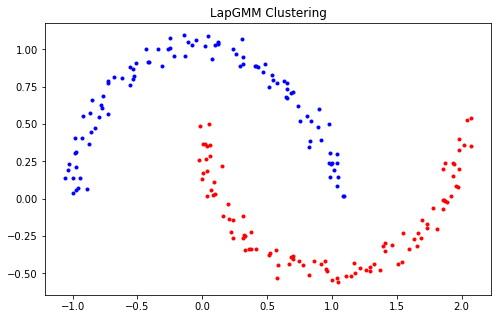

In [270]:
plt.plot(moons_pos[labels==1,0],moons_pos[labels==1,1],'b.')
plt.plot(moons_pos[labels==0,0],moons_pos[labels==0,1],'r.')
plt.title('LapGMM Clustering')

# Entropy analysis

## Experiment

- Now the algorithm has converged when setting tol = 1e-6, and gives the following reg_loglikelihood 

In [271]:
final_reg_ll = lapgmm.reg_loglikelihood
print('The algorithm gives reg_loglikelihood = ', final_reg_ll)

The algorithm gives reg_loglikelihood =  -368.0697727027633


- And if we run E-step now, which should do no harm to regularized log likelihood

In [278]:
# record the final posterior probability that the algorithm gives
post_prob_before_E_step = lapgmm.posterior_prob
# record the posterior probability if we run E-step further
post_prob_after_E_step = lapgmm._E_step()

In [279]:
# Calculate the regularized log likelihood after E-step
_, alpha_after_E_step, mu_after_E_step, sigma_after_E_step=lapgmm._M_step(post_prob_after_E_step,gamma=0.0)

reg_ll_after_E_step = lapgmm._Eval_Regularized_LL(post_prob_after_E_step,alpha_after_E_step,\
                            mu_after_E_step,sigma_after_E_step,lapgmm.data,verbose=True)
print('regularized log likelihood after E-step',reg_ll_after_E_step)

log_likelihood =  -359.946267510427
R =  6.268439268826506
regularized_ll =  -6628.385536336933
regularized log likelihood after E-step -6628.385536336933


- However

In [280]:
df = pd.DataFrame([{'Before_E_step':final_reg_ll,'After_E_step':reg_ll_after_E_step}])
df.index = ['Regularized Log Likelihood']
df

,Before_E_step,After_E_step
Regularized Log Likelihood,-368.069773,-6628.385536


- However, We notice that the performance (regularized log likelihood) decreases dramatically
- EM requires when we reset the posterior probability distribution (E-step), the performance can not decrease.
> In this algorithm, E-step and M-step are shooting at different target.
> E-step's target is pure log likelihood, shooting it using KL-divergence / Jensen's inequality.
> M-step's target is regularized log likelihood, shooting it using Newton-Raphson method and characteristic of normal distribution.
- This is not EM algorithm, at least it doesn't follow the spirit of EM. And this mixture doesn't seem to work well as expected.